# CX Build notes

In [16]:
using Revise
using FUSE
using IMAS
using Plots;
FUSE.logging(Logging.Info; actors=Logging.Debug);

## initialize inputs

In [17]:
dd = IMAS.dd()
ini, act = FUSE.case_parameters(:FPP, version=:v1_demount, init_from=:scalars);

In [18]:
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 0.8826 # set less than one so that init uses this as the f_kappa parameter
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0
ini.equilibrium.pressure_core = 1.5e6

delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

ini.core_profiles.impurity = :Kr
ini.core_profiles.zeff = 1.5
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 0.825
ini.core_profiles.greenwald_fraction = 1.0
ini.core_profiles.ne_ped = missing
ini.core_profiles.greenwald_fraction_ped = 0.7
ini.core_profiles.helium_fraction = 0.04

ini.build.plasma_gap = 0.125
ini.equilibrium.xpoints = :lower
ini.build.divertors = :lower
ini.build.symmetric = false

ini.ec_launchers.power_launched = [5e6, 15e6]

ini.pf_active.n_coils_outside = 8

ini.requirements.flattop_duration = 24*3600.0




86400.0

In [19]:
### modify ini layers

R0 = ini.equilibrium.R0
ϵ = ini.equilibrium.ϵ
a = R0 * ϵ

RiPlasma = R0 - a

# HFS layers

ini.build.layers[:plasma] = 2*a*(1+ini.build.plasma_gap)
ini.build.layers[:hfs_first_wall] = 0.02
ini.build.layers[:hfs_blanket] = 0.55*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_high_temp_shield] = RiPlasma*0.05
ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.02
ini.build.layers[:hfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:hfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_gap_low_temp_shield_TF] = RiPlasma * 0.02

rbCenterPost = (R0 - 0.5*ini.build.layers[:plasma] - ini.build.layers[:hfs_first_wall] - ini.build.layers[:hfs_blanket]
    - ini.build.layers[:hfs_high_temp_shield] - ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel]
    - ini.build.layers[:hfs_vacuum_vessel] - ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield]
    - ini.build.layers[:hfs_low_temp_shield] - ini.build.layers[:hfs_gap_low_temp_shield_TF]);

ini.build.layers[:hfs_TF] = rbCenterPost * 0.25
ini.build.layers[:OH] = rbCenterPost * 0.25
ini.build.layers[:gap_TF_OH] = RiPlasma * 0.02
ini.build.layers[:gap_OH] = rbCenterPost - ini.build.layers[:hfs_TF] - ini.build.layers[:gap_TF_OH] - ini.build.layers[:OH]

# LFS layers

ini.build.layers[:lfs_first_wall] = 0.02
ini.build.layers[:lfs_blanket] = 1.0 - 0.25*((1/ϵ-2.1)/1.9)^0.5
ini.build.layers[:lfs_high_temp_shield] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.2
ini.build.layers[:lfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:lfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:lfs_gap_low_temp_shield_TF] = RiPlasma * 0.02
ini.build.layers[:lfs_TF] = ini.build.layers[:hfs_TF]

0.47518464959602186

In [20]:
act.ActorEquilibrium.model = :Solovev
act.ActorEquilibrium.symmetrize = false

act.ActorECsimple.rho_0 = [0.0,0.6]
act.ActorECsimple.width = [0.05,0.05]

act.ActorPedestal.update_core_profiles = false
act.ActorPedestal.only_powerlaw = false
act.ActorPedestal.T_ratio_pedestal = 1.0

act.ActorHFSsizing.do_plot = true # false
act.ActorHFSsizing.verbose = true # false
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.error_on_technology = false
act.ActorHFSsizing.error_on_performance = false
act.ActorFluxSwing.operate_oh_at_j_crit = true

act.ActorPFcoilsOpt.do_plot = false
act.ActorPFcoilsOpt.update_equilibrium = false
act.ActorPFcoilsOpt.optimization_scheme = :none

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.2

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorStabilityLimits.raise_on_breach = false
act.ActorStabilityLimits.models = [:beta_troyon_1984, :model_201, :model_401] # include βn check

act.ActorCosting.model = :GASC
act.ActorCosting.production_increase = 10.0
act.ActorCosting.learning_rate = 0.616

act.ActorFixedProfiles.T_shaping = ini.core_profiles.T_shaping
act.ActorFixedProfiles.n_shaping = ini.core_profiles.n_shaping
act.ActorFixedProfiles.T_ratio_pedestal = 1.0
act.ActorFixedProfiles.T_ratio_core = ini.core_profiles.T_ratio

act.ActorCoreTransport.model = :FixedProfiles

act.ActorStationaryPlasma.convergence_error = 1e-2

0.01

## Run Actors

In [21]:
dd = IMAS.dd()
@time FUSE.init(dd, ini, act; do_plot=false);

[ Info: Equilibrium
[ Info:  Solovev
[ Info: HCD
[ Info:  ECsimple
[ Info:  ICsimple
[ Info:  LHsimple
[ Info:  NBsimple
[ Info: SteadyStateCurrent
[ Info: CXbuild


  7.818538 seconds (37.93 M allocations: 3.228 GiB, 7.18% gc time, 0.26% compilation time)


[ Info: StationaryPlasma
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple
[ Info:  Current
[ Info:   SteadyStateCurrent
[ Info:  CoreTransport
[ Info:   FixedProfiles
[ Info:    Pedestal
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple
[ Info:  Current
[ Info:   SteadyStateCurrent
[ Info:  Equilibrium
[ Info:   Solovev
[ Info:  CoreTransport
[ Info:   FixedProfiles
[ Info:    Pedestal
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple
[ Info:  Current
[ Info:   SteadyStateCurrent
[ Info:  Equilibrium
[ Info:   Solovev
[ Info: HFSsizing
[ Info:  FluxSwing
[ Info:  Stresses


(0.05942942412421482, [-1.800049511472877e-7, -0.008070643429892953, -0.2871112759031068, -0.06760030735491468, -6.75928685704774e-7, 0.0], [0.0])
Optimization Result
  Iteration:       50
  Minimum:         0.0594294
  Minimizer:       [0.163749, 0.100042, 0.787142, 0.799822]
  Function calls:  1000
  Feasibles:       20 / 20 in final population
  Total time:      3.4820 s
  Stop reason:     Maximum number of iterations exceeded.


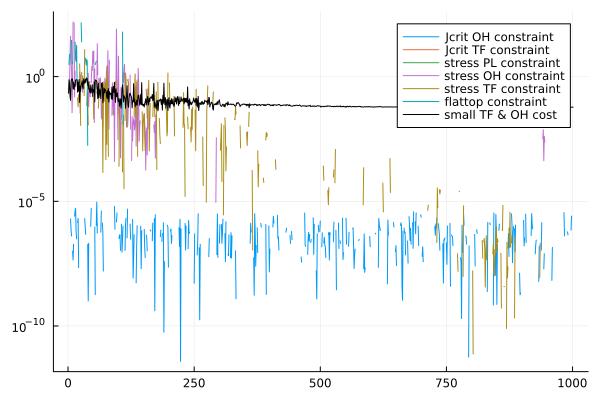

[PL.thickness] = [1.3685271421769596]
[OH.thickness, dd.build.oh.technology.fraction_steel] = [0.15212924325553698, 0.7871419860917618]
[TFhfs.thickness, dd.build.tf.technology.fraction_steel] = [0.3112607131537099, 0.7998218926654532]

target_B0 = 4.7132230516390665
(dd.build.tf.max_b_field * TFhfs.end_radius) / R0 = 4.713299913006832

dd.build.oh.flattop_duration = 186138.91319754565
dd.requirements.flattop_duration = 86400.0
dd.build.oh.flattop_duration / dd.requirements.flattop_duration = 2.154385569416038

dd.build.oh.max_j = 5.656819074705897e7
dd.build.oh.critical_j = 8.488830167258477e7
dd.build.oh.critical_j / dd.build.oh.max_j = 1.5006366749850168

dd.build.tf.max_j = 3.3310754012408894e7
dd.build.tf.critical_j = 6.752185295745584e7
dd.build.tf.critical_j / dd.build.tf.max_j = 2.027028656640515

maximum(cs.stress.vonmises.oh) = 7.209213782056018e8
cs.properties.yield_strength.oh = 8.0e8
cs.properties.yield_strength.oh / maximum(cs.stress.vonmises.oh) = 1.1096910484070088

max

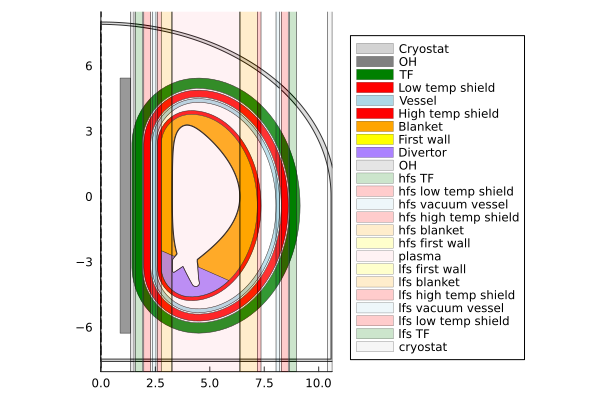

[ Info: LFSsizing


In [22]:
FUSE.ActorStationaryPlasma(dd, act);
FUSE.ActorHFSsizing(dd, act);
FUSE.ActorLFSsizing(dd, act);

In [24]:
dd0 = deepcopy(dd);

In [25]:
FUSE.ActorCXbuild(dd0, act);

[ Info: CXbuild


## Break down cx_actor

In [26]:
dd0 = deepcopy(dd);

In [27]:
bd = dd0.build;
eqt = dd0.equilibrium.time_slice[]
divertor_length_fraction = 0.2

import IMAS: BuildLayerType, _plasma_, _gap_, _oh_, _tf_, _shield_, _blanket_, _wall_, _vessel_, _cryostat_, _divertor_
import IMAS: BuildLayerSide, _lfs_, _lhfs_, _hfs_, _in_, _out_
import IMAS: BuildLayerShape, _offset_, _negative_offset_, _convex_hull_, _princeton_D_exact_, _princeton_D_, _princeton_D_scaled_, _rectangle_, _double_ellipse_, _triple_arc_, _miller_, _square_miller_, _spline_, _silo_
import FUSE: shape_function, initialize_shape_parameters, buffer, xy_polygon, rectangle_shape, convex_hull, line_through_point
using PolygonOps
using LibGEOS
using GeoInterface

### wall_from_eq

In [28]:
function wall_from_eq(bd::IMAS.build, eqt::IMAS.equilibrium__time_slice; divertor_length_fraction::Real=0.2)
    R0 = eqt.global_quantities.magnetic_axis.r
    Z0 = eqt.global_quantities.magnetic_axis.z

    # lcfs
    ψb = IMAS.find_psi_boundary(eqt)
    rlcfs, zlcfs, _ = IMAS.flux_surface(eqt, ψb, true)

    # Set the radial build thickness of the plasma
    plasma = IMAS.get_build_layer(bd.layer, type=_plasma_)
    a = (minimum(rlcfs) - plasma.start_radius)
    plasma.thickness = maximum(rlcfs) - minimum(rlcfs) + 2.0 * a
    R_hfs_plasma = plasma.start_radius
    R_lfs_plasma = plasma.end_radius

    # main chamber (clip elements that go beyond plasma radial build thickness)
    R, Z = buffer(rlcfs, zlcfs, a)
    R[R.<R_hfs_plasma] .= R_hfs_plasma
    R[R.>R_lfs_plasma] .= R_lfs_plasma
    Z = (Z .- Z0) .* 1.05 .+ Z0
    wall_poly = xy_polygon(R, Z)

    t = LinRange(0, 2π, 31)

    # divertor lengths
    linear_plasma_size = maximum(zlcfs) - minimum(zlcfs)
    max_divertor_length = linear_plasma_size * divertor_length_fraction

    detected_upper = bd.divertors.upper.installed
    detected_lower = bd.divertors.lower.installed

    # private flux regions sorted by distance from lcfs
    private = IMAS.flux_surface(eqt, ψb, false)
    sort!(private; by=p -> IMAS.minimum_distance_two_shapes(p..., rlcfs, zlcfs))

    for (pr, pz) in private

        if sign(pz[1] - Z0) != sign(pz[end] - Z0)
            # handle Solovev cases with flux surface that crosses midplane
            
            if detected_lower == 1 && detected_upper == 0
                ispos = pz .> 0 
                deleteat!(pz,ispos)
                deleteat!(pr,ispos)
            elseif detected_upper == 1 && detected_lower == 0
                isneg = pz .< 0
                deleteat!(pz,isneg)
                deleteat!(pr,isneg)
            else
                continue
            end
        end

        # xpoint between lcfs and private region
        index = IMAS.minimum_distance_two_shapes(pr, pz, rlcfs, zlcfs; return_index=true)
        Rx = (pr[index[1]] + rlcfs[index[2]]) / 2.0
        Zx = (pz[index[1]] + zlcfs[index[2]]) / 2.0
        d = sqrt((pr[index[1]] - rlcfs[index[2]])^2 + (pz[index[1]] - zlcfs[index[2]])^2)
        if d > linear_plasma_size / 5
            continue
        end

        # check that this divertor is in fact installed
        if Zx > Z0 && (ismissing(bd.divertors.upper, :installed) || bd.divertors.upper.installed != 1)
            continue
        elseif Zx < Z0 && (ismissing(bd.divertors.lower, :installed) || bd.divertors.lower.installed != 1)
            continue
        end

        max_d = maximum(sqrt.((Rx .- pr) .^ 2.0 .+ (Zx .- pz) .^ 2.0))
        divertor_length = min(max_d * 0.8, max_divertor_length)

        # limit extent of private flux regions
        circle = collect(zip(divertor_length .* cos.(t) .+ Rx, sign(Zx) .* divertor_length .* sin.(t) .+ Zx))
        circle[1] = circle[end]
        slot = [(rr, zz) for (rr, zz) in zip(pr, pz) if PolygonOps.inpolygon((rr, zz), circle) == 1 && rr >= R_hfs_plasma && rr <= R_lfs_plasma]
        pr1 = [rr for (rr, zz) in slot]
        pz1 = [zz for (rr, zz) in slot]
        if isempty(pr1)
            continue
        end

        # do not add more than one private flux region for each of the x-points
        if Zx > Z0
            if detected_upper == 0
                continue
            end
            detected_upper -= 1
        else
            if detected_lower == 0
                continue
            end
            detected_lower -= 1
        end

        # add the divertor slots
        α = 0.2
        pr2 = vcat(pr1, R0 * α + Rx * (1 - α))
        pz2 = vcat(pz1, Z0 * α + Zx * (1 - α))
        slot = LibGEOS.buffer(xy_polygon(pr2, pz2), a)
        wall_poly = LibGEOS.union(wall_poly, slot)
    end

    # detect if equilibrium has x-points to define build of divertors
    if detected_upper != 0 || detected_lower != 0
        display(plot(eqt))
        error("Equilibrium does not allow building the right number of upper ($(bd.divertors.upper.installed)→$(-detected_upper+bd.divertors.upper.installed)) and lower ($(bd.divertors.lower.installed)→$(-detected_lower+bd.divertors.lower.installed)) divertors.")
    end

    # vertical clip
    wall_poly = LibGEOS.difference(wall_poly, xy_polygon(rectangle_shape(0.0, R_hfs_plasma, 100.0)...))
    wall_poly = LibGEOS.difference(wall_poly, xy_polygon(rectangle_shape(R_lfs_plasma, 10 * R_lfs_plasma, 100.0)...))

    # round corners
    wall_poly = LibGEOS.buffer(wall_poly, -a / 4)
    wall_poly = LibGEOS.buffer(wall_poly, a / 4)

    pr = [v[1] for v in GeoInterface.coordinates(wall_poly)[1]]
    pz = [v[2] for v in GeoInterface.coordinates(wall_poly)[1]]

    pr, pz = IMAS.resample_2d_path(pr, pz; step=0.1)

    return pr, pz
end

wall_from_eq (generic function with 1 method)

### divertor_regions

In [29]:
function divertor_regions!(bd::IMAS.build, eqt::IMAS.equilibrium__time_slice, divertors::IMAS.divertors)
    R0 = eqt.global_quantities.magnetic_axis.r
    Z0 = eqt.global_quantities.magnetic_axis.z

    # plasma poly (this sets the divertor's pfs)
    ipl = IMAS.get_build_index(bd.layer, type=_plasma_)
    plasma_poly = xy_polygon(bd.layer[ipl])
    pl_r = bd.layer[ipl].outline.r
    pl_z = bd.layer[ipl].outline.z
    pl_r[1] = pl_r[end]
    pl_z[1] = pl_z[end]
    IMAS.reorder_flux_surface!(pl_r, pl_z, R0, Z0)

    # wall poly (this sets how back the divertor structure goes)
    wall_poly = xy_polygon(bd.layer[ipl-1])
    for ltype in (_blanket_, _shield_, _wall_)
        iwls = IMAS.get_build_indexes(bd.layer, type=ltype, fs=_hfs_)
        if !isempty(iwls)
            wall_poly = xy_polygon(bd.layer[iwls[1]])
            break
        end
    end
    wall_rz = [v for v in GeoInterface.coordinates(wall_poly)[1]]

    ψb = IMAS.find_psi_boundary(eqt)
    rlcfs, zlcfs, _ = IMAS.flux_surface(eqt, ψb, true)
    linear_plasma_size = maximum(zlcfs) - minimum(zlcfs)

    empty!(divertors)

    detected_upper = bd.divertors.upper.installed
    detected_lower = bd.divertors.lower.installed

    private = IMAS.flux_surface(eqt, ψb, false)
    sort!(private; by=p -> IMAS.minimum_distance_two_shapes(p..., rlcfs, zlcfs))
    for (pr, pz) in private
        if sign(pz[1] - Z0) != sign(pz[end] - Z0)
            # handle Solovev cases with flux surface that crosses midplane
            
            if detected_lower == 1 && detected_upper == 0
                ispos = pz .> 0 
                deleteat!(pz,ispos)
                deleteat!(pr,ispos)
            elseif detected_upper == 1 && detected_lower == 0
                isneg = pz .< 0
                deleteat!(pz,isneg)
                deleteat!(pr,isneg)
            else
                continue
            end
        end

        # xpoint between lcfs and private region
        index = IMAS.minimum_distance_two_shapes(pr, pz, rlcfs, zlcfs; return_index=true)
        Rx = (pr[index[1]] + rlcfs[index[2]]) / 2.0
        Zx = (pz[index[1]] + zlcfs[index[2]]) / 2.0
        d = sqrt((pr[index[1]] - rlcfs[index[2]])^2 + (pz[index[1]] - zlcfs[index[2]])^2)
        if d > linear_plasma_size / 5
            continue
        end

        # check that this divertor is in fact installed
        if Zx > Z0 && (ismissing(bd.divertors.upper, :installed) || bd.divertors.upper.installed != 1)
            continue
        elseif Zx < Z0 && (ismissing(bd.divertors.lower, :installed) || bd.divertors.lower.installed != 1)
            continue
        end

        # private flux region must be in the wall
        prz = [(rr, zz) for (rr, zz) in zip(pr, pz) if PolygonOps.inpolygon((rr, zz), wall_rz) == 1]
        pr = [rr for (rr, zz) in prz]
        pz = [zz for (rr, zz) in prz]
        if length(pr) < 5
            continue
        end

        if Zx > Z0
            if detected_upper == 0
                continue
            end
            detected_upper -= 1
        else
            if detected_lower == 0
                continue
            end
            detected_lower -= 1
        end

        if Zx > Z0
            ul_name = "upper"
        else
            ul_name = "lower"
        end

        # Define divertor region by tracing a line going through X-point
        # and perpendicular to line connecting X-point to magnetic axis
        m = (Zx - Z0) / (Rx - R0)
        xx = [0.0, R0 * 2.0]
        yy = line_through_point(-1.0 ./ m, Rx, Zx, xx)
        domain_r = vcat(xx, reverse(xx), xx[1])
        domain_z = vcat(yy, [Zx * 5.0, Zx * 5.0], yy[1])
        domain_poly = xy_polygon(domain_r, domain_z)
        divertor_poly = LibGEOS.intersection(wall_poly, domain_poly)
        divertor_poly = LibGEOS.difference(divertor_poly, plasma_poly)

        # Assign to build structure
        coords = GeoInterface.coordinates(divertor_poly)
        structure = resize!(bd.structure, "type" => Int(_divertor_), "name" => "$ul_name divertor")
        structure.material = "Tungsten"
        structure.outline.r = [v[1] for v in coords[1]]
        structure.outline.z = [v[2] for v in coords[1]]
        structure.toroidal_extent = 2pi

        # now find divertor plasma facing surfaces
        indexes, crossings = IMAS.intersection(xx, yy, pl_r, pl_z)
        divertor_r = [crossings[1][1]; pl_r[indexes[1][2]+1:indexes[2][2]+1]; crossings[2][1]]
        divertor_z = [crossings[1][2]; pl_z[indexes[1][2]+1:indexes[2][2]+1]; crossings[2][2]]

        # split inner/outer based on line connecting X-point to magnetic axis
        m = (Zx - Z0) / (Rx - R0)
        xx = [0.0, R0 * 2.0]
        yy = line_through_point(m, Rx, Zx, xx)
        indexes, crossings = IMAS.intersection(xx, yy, divertor_r, divertor_z)

        # add target info
        divertor = resize!(divertors.divertor, length(divertors.divertor) + 1)[end]
        for io_name in ("inner", "outer")
            target = resize!(divertor.target, "name" => "$ul_name $io_name target")
            tile = resize!(target.tile, "name" => "$ul_name $io_name tile")
            if ul_name == "upper"
                if io_name == "outer"
                    divertor_pfs_r = divertor_r[indexes[1][2]:end]
                    divertor_pfs_z = divertor_z[indexes[1][2]:end]
                else
                    divertor_pfs_r = divertor_r[1:indexes[1][2]]
                    divertor_pfs_z = divertor_z[1:indexes[1][2]]
                end
            else
                if io_name == "outer"
                    divertor_pfs_r = divertor_r[1:indexes[1][2]]
                    divertor_pfs_z = divertor_z[1:indexes[1][2]]
                else
                    divertor_pfs_r = divertor_r[indexes[1][2]:end]
                    divertor_pfs_z = divertor_z[indexes[1][2]:end]
                end
            end
            tile.surface_outline.r = divertor_pfs_r
            tile.surface_outline.z = divertor_pfs_z
        end
    end

    return nothing
end

divertor_regions! (generic function with 1 method)

### blanket_regions

In [30]:
function blanket_regions!(bd::IMAS.build, eqt::IMAS.equilibrium__time_slice)
    R0 = eqt.global_quantities.magnetic_axis.r

    layers = bd.layer
    iblankets = IMAS.get_build_indexes(bd.layer; type=_blanket_, fs=_lfs_)
    if isempty(iblankets)
        return nothing
    end
    iblanket = iblankets[1]
    layer = layers[iblanket]
    layer_in = layers[iblanket-1]

    layer_poly = xy_polygon(layer)
    layer_in_poly = xy_polygon(layer_in)
    ring_poly = LibGEOS.difference(layer_poly, layer_in_poly)
    for structure in (structure for structure in bd.structure if structure.type == Int(_divertor_))
        structure_poly = xy_polygon(structure)
        ring_poly = LibGEOS.difference(ring_poly, structure_poly)
    end

    geometries = LibGEOS.getGeometries(ring_poly)
    for poly in geometries
        coords = GeoInterface.coordinates(poly)
        pr = [v[1] for v in coords[1]]
        pz = [v[2] for v in coords[1]]

        # assign to build structure
        if length(geometries) == 2
            if sum(pr) / length(pr) > R0
                name = "LFS blanket"
            else
                name = "HFS blanket"
            end
        else
            name = "blanket"
        end

        structure = resize!(bd.structure, "type" => Int(_blanket_), "name" => name)
        structure.outline.r = pr
        structure.outline.z = pz
        structure.toroidal_extent = 2pi
    end

    return nothing
end

blanket_regions! (generic function with 1 method)

### optimize_shape

In [31]:
function optimize_shape(bd::IMAS.build, obstr_index::Int, layer_index::Int, shape::BuildLayerShape; tight::Bool=true)
    layer = bd.layer[layer_index]
    obstr = bd.layer[obstr_index]
    # display("Layer $layer_index = $(layer.name)")
    # display("Obstr $obstr_index = $(obstr.name)")
    if layer.fs == Int(_out_)
        l_start = 0.0
        l_end = layer.end_radius
        o_start = 0.0
        o_end = obstr.end_radius
    else
        if obstr.fs in (Int(_lhfs_), Int(_out_))
            o_start = obstr.start_radius
            o_end = obstr.end_radius
        else
            o_start = obstr.start_radius
            o_end = IMAS.get_build_layer(bd.layer, identifier=obstr.identifier, fs=_lfs_).end_radius
        end
        l_start = layer.start_radius
        if layer.type == Int(_plasma_)
            l_end = layer.end_radius
        else
            l_end = IMAS.get_build_layer(bd.layer, identifier=layer.identifier, fs=_lfs_).end_radius
        end
    end
    hfs_thickness = o_start - l_start
    lfs_thickness = l_end - o_end
    oR = obstr.outline.r
    oZ = obstr.outline.z
    if layer.fs == Int(_out_)
        target_clearance = lfs_thickness * 1.2
        use_curvature = false
    else
        use_curvature = true
        if tight
            target_clearance = min(hfs_thickness, lfs_thickness)
        else
            target_clearance = sqrt(hfs_thickness^2 + lfs_thickness^2) / 2.0
        end
    end
    r_offset = (lfs_thickness .- hfs_thickness) / 2.0

    # update shape
    layer.shape = Int(shape)

    # handle offset, negative offset, and convex-hull
    if layer.shape in (Int(_offset_), Int(_negative_offset_), Int(_convex_hull_))
        R, Z = buffer(oR, oZ, (hfs_thickness + lfs_thickness) / 2.0)
        R .+= r_offset
        if layer.shape == Int(_convex_hull_)
            hull = convex_hull(R, Z; closed_polygon=true)
            R = [r for (r, z) in hull]
            Z = [z for (r, z) in hull]
            # resample disabled because this can lead to outlines of different layers to be crossing
            # R, Z = IMAS.resample_2d_path(R, Z)
        end
        layer.outline.r, layer.outline.z = R, Z

    else # handle shapes
        if layer.shape > 1000
            layer.shape = mod(layer.shape, 1000)
        end
        if layer.shape > 100
            layer.shape = mod(layer.shape, 100)
        end

        if layer.shape == Int(_silo_)
            is_up_down_symmetric = false
        elseif abs(sum(oZ) / sum(abs.(oZ))) < 1E-2
            is_up_down_symmetric = true
        else
            is_up_down_symmetric = false
        end

        is_negative_D = false
        if layer.shape != Int(_silo_)
            _, imaxr = findmax(oR)
            _, iminr = findmin(oR)
            _, imaxz = findmax(oZ)
            _, iminz = findmin(oZ)
            r_at_max_z, max_z = oR[imaxz], oZ[imaxz]
            r_at_min_z, min_z = oR[iminz], oZ[iminz]
            z_at_max_r, max_r = oZ[imaxr], oR[imaxr]
            z_at_min_r, min_r = oZ[iminr], oR[iminr]
            a = 0.5 * (max_r - min_r)
            R = 0.5 * (max_r + min_r)
            δu = (R - r_at_max_z) / a
            δl = (R - r_at_min_z) / a
            if δu + δl < -0.1
                is_negative_D = true
            end
        end

        if is_negative_D
            layer.shape = layer.shape + 1000
        end

        if !is_up_down_symmetric
            layer.shape = layer.shape + 100
        end

        func = shape_function(layer.shape, resolution=1.0)
        layer.shape_parameters = initialize_shape_parameters(layer.shape, oR, oZ, l_start, l_end, target_clearance)

        layer.outline.r, layer.outline.z = func(l_start, l_end, layer.shape_parameters...)
        layer.shape_parameters = FUSE.optimize_shape(oR, oZ, target_clearance, func, l_start, l_end, layer.shape_parameters; use_curvature)
        layer.outline.r, layer.outline.z = func(l_start, l_end, layer.shape_parameters...; resample=false)
    end

    IMAS.reorder_flux_surface!(layer.outline.r, layer.outline.z)
    # display(plot(layer.outline.r, layer.outline.z; aspect_ratio=:equal))
end

optimize_shape (generic function with 1 method)

### build_cx

In [32]:
function build_cx!(bd::IMAS.build, pr::Vector{Float64}, pz::Vector{Float64})
    plasma = IMAS.get_build_layer(bd.layer, type=_plasma_)

    # _plasma_ outline scaled to match 1D radial build
    start_radius = plasma.start_radius
    end_radius = plasma.end_radius
    pr1 = minimum(pr)
    pr2 = maximum(pr)
    fact = (end_radius - start_radius) / (pr2 - pr1)
    pz .= pz .* fact
    pr .= (pr .- pr1) .* fact .+ start_radius
    plasma.outline.r = pr
    plasma.outline.z = pz

    coils_inside = any([contains(lowercase(l.name), "coils") for l in bd.layer])

    # all layers between plasma and TF
    # k-1 means the layer outside (ie. towards the tf)
    # k   is the current layer
    # k+1 means the layer inside (ie. towards the plasma)
    tf_to_plasma = IMAS.get_build_indexes(bd.layer, fs=_hfs_)
    plasma_to_tf = reverse(tf_to_plasma)
    for k in plasma_to_tf
        layer_shape = BuildLayerShape(mod(mod(bd.layer[k].shape, 1000), 100))
        @debug "$(bd.layer[k].name) $(layer_shape)"
        optimize_shape(bd, k + 1, k, layer_shape; tight=!coils_inside)
    end

    # _in_
    TF = IMAS.get_build_layer(bd.layer, type=_tf_, fs=_hfs_)
    D = minimum(TF.outline.z)
    U = maximum(TF.outline.z)
    if coils_inside
        # generally the OH does not go higher than the PF coils
        D += 2.0 * TF.thickness
        U -= 2.0 * TF.thickness
    end
    for k in IMAS.get_build_indexes(bd.layer, fs=_in_)
        L = bd.layer[k].start_radius
        R = bd.layer[k].end_radius
        bd.layer[k].outline.r, bd.layer[k].outline.z = rectangle_shape(L, R, D, U)
    end

    # _out_
    iout = IMAS.get_build_indexes(bd.layer, fs=_out_)
    if lowercase(bd.layer[iout[end]].name) == "cryostat"
        olfs = IMAS.get_build_indexes(bd.layer, fs=_lfs_)[end]
        optimize_shape(bd, olfs, iout[end], _silo_)
        for k in reverse(iout[2:end])
            optimize_shape(bd, k, k - 1, _negative_offset_)
        end
    else
        for k in iout
            L = 0.0
            R = bd.layer[k].end_radius
            D = minimum(bd.layer[k-1].outline.z) - bd.layer[k].thickness
            U = maximum(bd.layer[k-1].outline.z) + bd.layer[k].thickness
            bd.layer[k].outline.r, bd.layer[k].outline.z = rectangle_shape(L, R, D, U)
        end
    end

    return bd
end

build_cx! (generic function with 1 method)

### step

In [33]:
actor = FUSE.ActorCXbuild(dd, act.ActorCXbuild);

dd = actor.dd
par = actor.par

bd = dd.build
div = dd.divertors
eqt = dd.equilibrium.time_slice[]

# If wall information is missing, then the first wall information is generated starting from equilibrium time_slice
wall = IMAS.first_wall(dd.wall)
if wall === missing || par.rebuild_wall
    pr, pz = wall_from_eq(bd, eqt)
else
    pr = wall.r
    pz = wall.z
end

# empty layer outlines and structures
for layer in bd.layer
    empty!(layer.outline)
end
empty!(bd.structure)

build_cx!(bd, pr, pz)

divertor_regions!(bd, eqt, dd.divertors)

blanket_regions!(bd, eqt)

if wall === missing || par.rebuild_wall
    plasma = IMAS.get_build_layer(bd.layer, type=_plasma_)
    resize!(dd.wall.description_2d, 1)
    resize!(dd.wall.description_2d[1].limiter.unit, 1)
    dd.wall.description_2d[1].limiter.unit[1].outline.r = plasma.outline.r
    dd.wall.description_2d[1].limiter.unit[1].outline.z = plasma.outline.z
end

IMAS.find_strike_points!(eqt, dd.divertors)

([3.2741191244241254, 4.437018125459113], [-3.1968966654655984, -4.11952766025528], [1.4751343184574606, 1.4946367118285795])

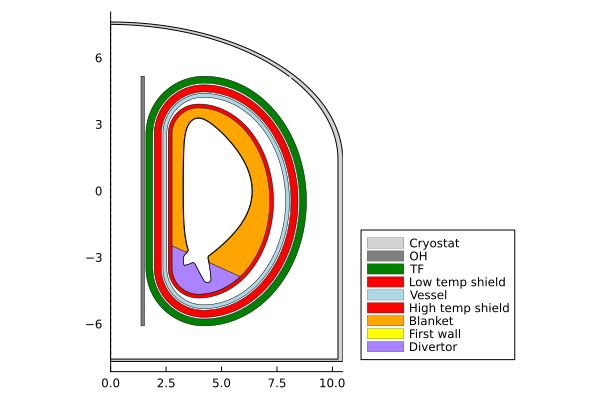

In [35]:
plot(dd.build)